In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/disease-plants/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4940 files belonging to 7 classes.


In [4]:
class_names= dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy']

In [5]:
len(dataset)

155

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 6 0 5 5 0 2 5 2 2 2 3 2 0 4 6 2 3 2 6 6 2 4 0 2 2 0 3 3 0 5 1]


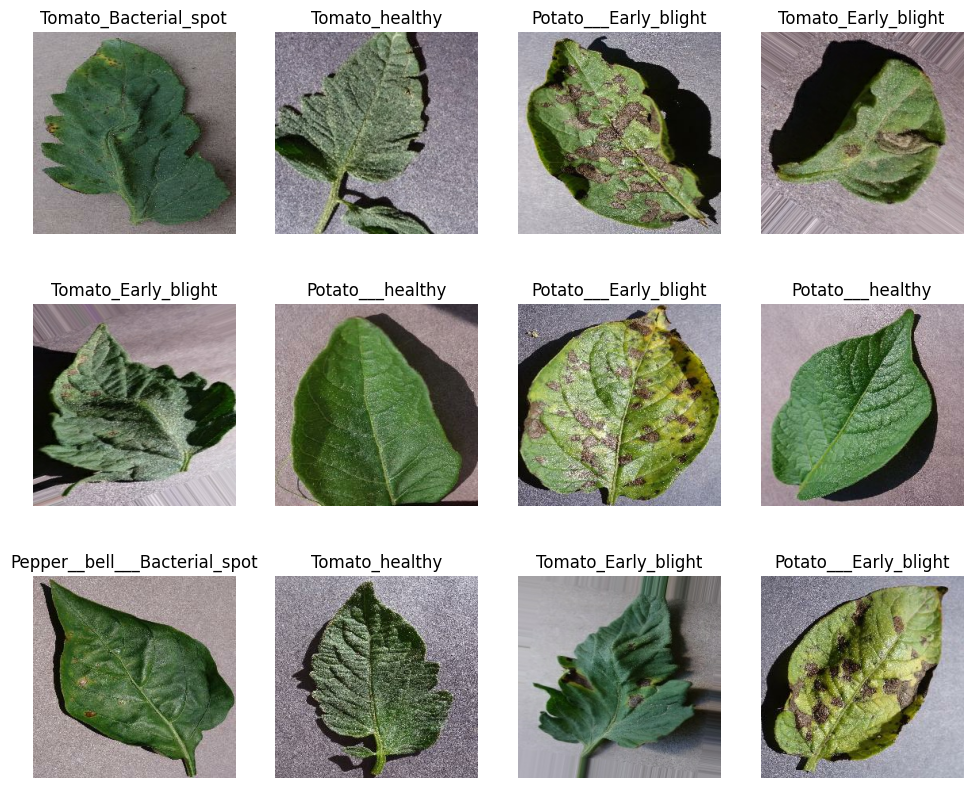

In [10]:
plt.figure(figsize=(12, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
train_size = 0.8
len(dataset)*train_size

124.0

In [12]:
# SETTING VALUES TO TRAIN , TEST AND VALIDATE MODEL
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds





In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

124

In [15]:
len(val_ds)

15

In [16]:
len(test_ds)

16

In [ ]:
#PREPROCESSING

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE=256
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [20]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
  layers.RandomBrightness(0.1)
    
])


In [ ]:
#MODEL TRAINING

In [61]:
base_model = tf.keras.applications.VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                           include_top=False,
                                           weights='imagenet')
# Unfreeze the top layers of the VGG16 model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True


In [62]:


input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [64]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [66]:
# Check dataset
print("Dataset loaded. Number of classes:", len(dataset.class_names))
for image_batch, labels_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)




Dataset loaded. Number of classes: 7
Image batch shape: (32, 256, 256, 3)
Labels batch shape: (32,)


In [67]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50


2024-11-11 13:33:50.365993: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[32,128,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-11 13:33:50.421280: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.055397257s
Trying algorithm eng18{k11=2} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[32,128,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_q

124/124 ━━━━━━━━━━━━━━━━━━━━ 135s 722ms/step - accuracy: 0.1407 - loss: 3.8118 - val_accuracy: 0.1354 - val_loss: 1.9395
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 505ms/step - accuracy: 0.1409 - loss: 1.9388 - val_accuracy: 0.2229 - val_loss: 1.8846
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 505ms/step - accuracy: 0.1954 - loss: 1.9055 - val_accuracy: 0.3229 - val_loss: 1.7413
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 507ms/step - accuracy: 0.1482 - loss: 1.9455 - val_accuracy: 0.1813 - val_loss: 1.8758
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 512ms/step - accuracy: 0.1726 - loss: 1.9037 - val_accuracy: 0.1792 - val_loss: 1.9080
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 509ms/step - accuracy: 0.1377 - loss: 1.9482 - val_accuracy: 0.3271 - val_loss: 1.7735
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 63s 511ms/step - accuracy: 0.2122 - loss: 1.8761 - val_accuracy: 0.3417 - val_loss: 1.6262
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 64s 516ms/step - accuracy: 0.3626 - loss: 1.5374 - va

In [71]:
scores = model.evaluate(test_ds)



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9856 - loss: 0.0623


In [72]:
acc_score= 0.9856*100
print(f" Accuracy: {acc_score}")

 Accuracy: 98.56


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


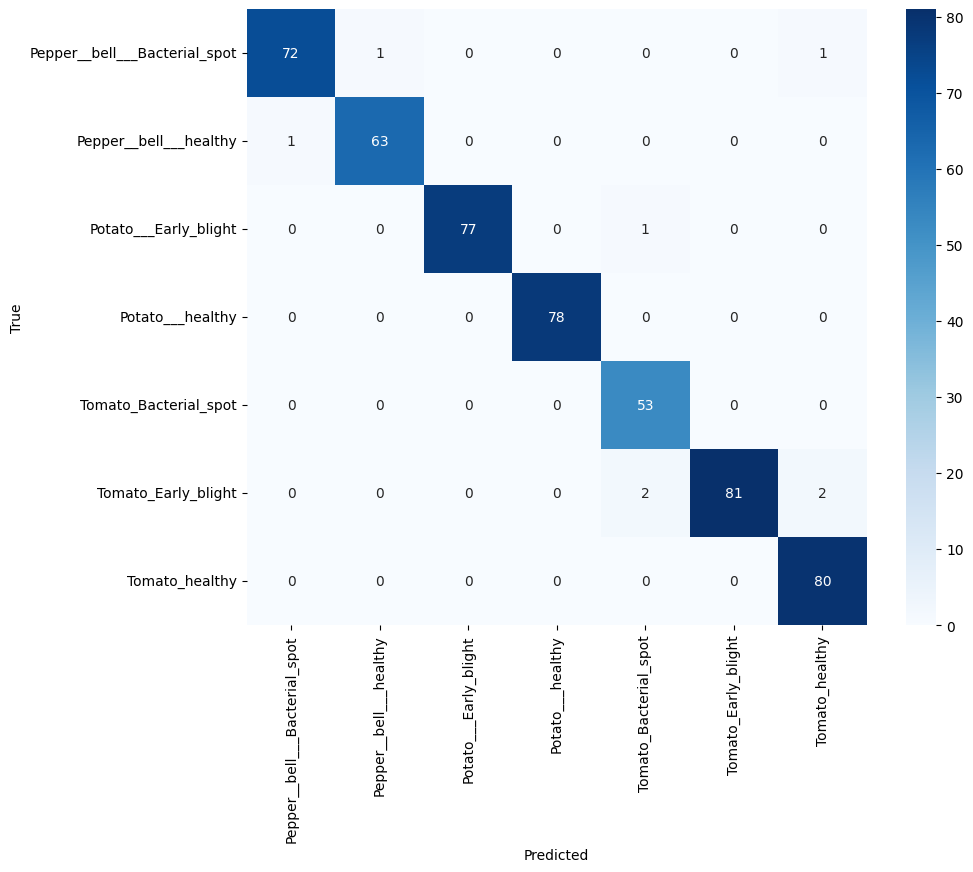

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predict on the test dataset and generate classification report
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report
report = classification_report(test_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(report)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.99      0.97      0.98        74
       Pepper__bell___healthy       0.98      0.98      0.98        64
        Potato___Early_blight       1.00      0.99      0.99        78
             Potato___healthy       1.00      1.00      1.00        78
        Tomato_Bacterial_spot       0.95      1.00      0.97        53
          Tomato_Early_blight       1.00      0.95      0.98        85
               Tomato_healthy       0.96      1.00      0.98        80

                     accuracy                           0.98       512
                    macro avg       0.98      0.99      0.98       512
                 weighted avg       0.98      0.98      0.98       512



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


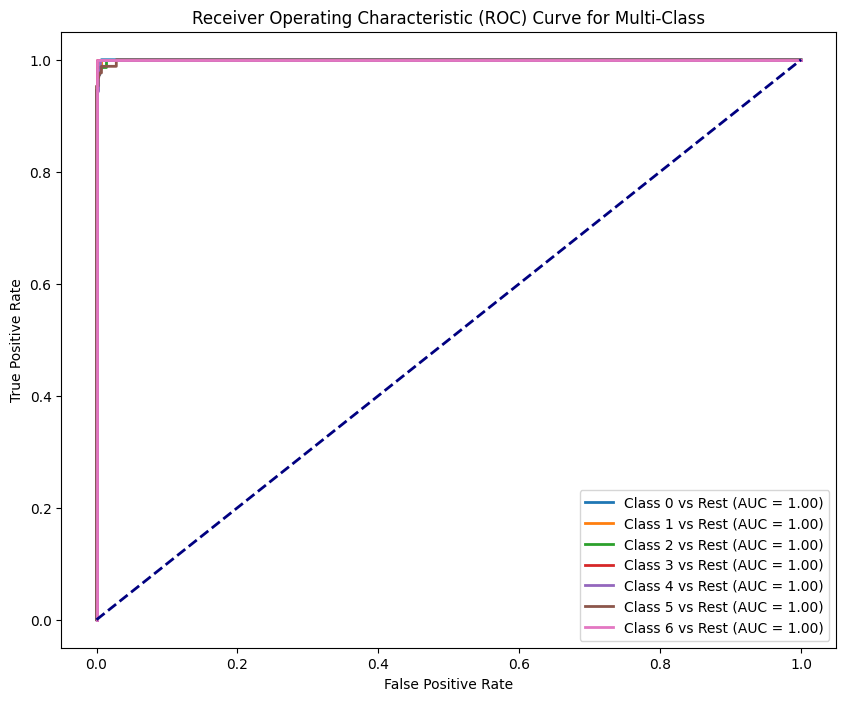

Overall AUC-ROC: 1.00


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC AUC
test_labels_binarized = label_binarize(test_labels, classes=range(n_classes))
# Predict probabilities for the test dataset
y_pred_prob = model.predict(test_ds)

# Create a plot for the ROC curve
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
for i, class_label in enumerate(range(n_classes)):
    # Calculate ROC curve for the current class
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} vs Rest (AUC = {roc_auc:.2f})')

# Plot the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Optionally, calculate the overall multi-class AUC-ROC
auc_roc = roc_auc_score(test_labels_binarized, y_pred_prob, multi_class='ovr')
print(f"Overall AUC-ROC: {auc_roc:.2f}")

In [ ]:
#CHECKING THE EPOCHS

In [76]:
history

In [54]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 124}

In [ ]:
history.history.keys()

In [79]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.441894054412842,
 1.93727445602417,
 1.893460988998413,
 1.9471508264541626,
 1.9178712368011475]

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

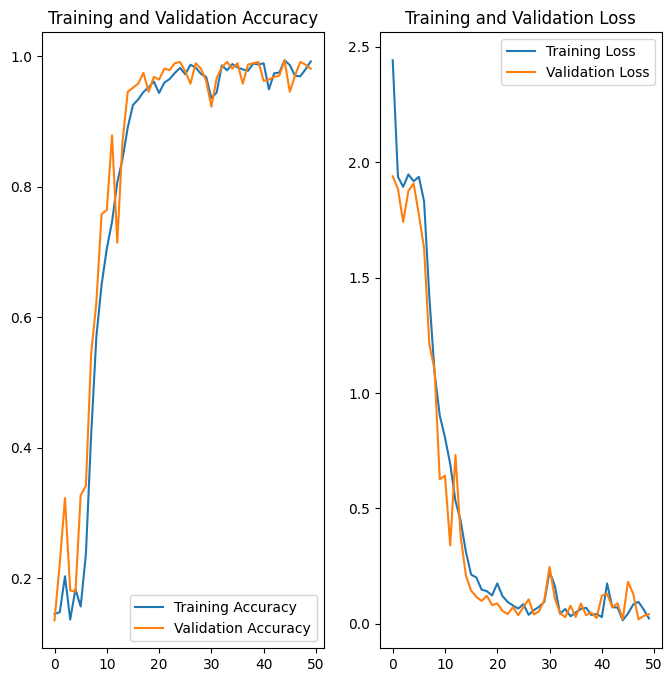

In [81]:
import matplotlib.pyplot as plt

# Number of epochs actually used in training
num_epochs = len(acc)

plt.figure(figsize=(8, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
#SAMPLE PREDICTION

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [82]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


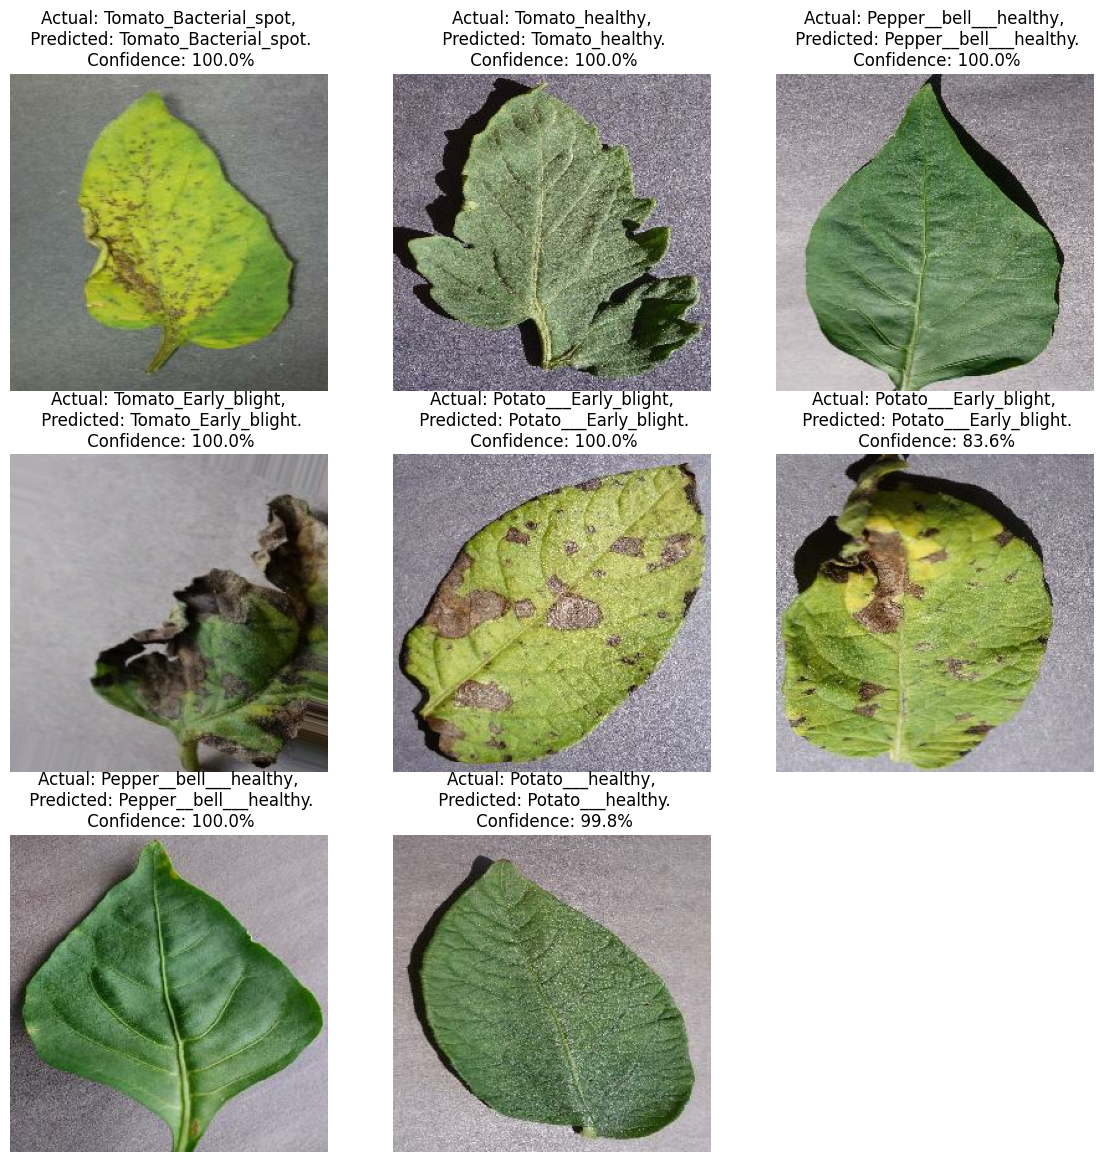

In [84]:
import numpy as np
plt.figure(figsize=(14, 14))

for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


In [ ]:
model.save('/kaggle/working/vgg.h5')
